In [33]:
from zipfile import ZipFile
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os
import cv2

import matplotlib.pyplot as plt

In [196]:
def preproc_data():
    targets, samples = [], []

    with ZipFile("fotoarc.zip", "r") as zip_data:
        cnt = 0
        for file in zip_data.filelist:
            cnt += 1
            name = file.filename
            zip_data.extract(name, path="fotoarc/")

            yuv = cv2.cvtColor(cv2.imread('fotoarc/' + name), cv2.COLOR_RGB2LUV)

            samples += [yuv[:, :, 0]]
            targets += [yuv[:, :, 1:]]

            os.remove("fotoarc/" + name)
            
            if cnt == 6:
                plt.imshow(cv2.cvtColor(yuv, cv2.COLOR_LUV2RGB))
                print(yuv)
                print(type(yuv[0, 0, 0]))
                print("-" * 100)
                print(cv2.cvtColor(yuv, cv2.COLOR_LUV2RGB))

            if cnt == 10:
                break

    x_train, x_test, y_train, y_test = train_test_split(samples,
                                                        targets,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=42)


    return TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train)),\
           TensorDataset(torch.Tensor(x_test),  torch.Tensor(y_test))

[[[229 108 154]
  [229 108 154]
  [229 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [226 108 154]]

 [[227 108 154]
  [228 108 154]
  [228 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [227 108 154]]

 [[228 108 154]
  [228 108 154]
  [228 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [227 108 154]]

 ...

 [[178 105 155]
  [175 105 155]
  [144 107 154]
  ...
  [ 98 103 151]
  [ 67 103 149]
  [ 65 103 149]]

 [[199 106 157]
  [227 107 157]
  [227 108 156]
  ...
  [ 56 103 148]
  [ 60 102 148]
  [ 65 102 149]]

 [[ 63 107 153]
  [137 107 158]
  [124 110 156]
  ...
  [ 49 103 148]
  [ 49 102 147]
  [ 65 102 149]]]
<class 'numpy.uint8'>
----------------------------------------------------------------------------------------------------
[[[246 222 201]
  [246 222 201]
  [246 222 201]
  ...
  [244 219 199]
  [244 219 199]
  [243 218 198]]

 [[244 219 199]
  [245 221 200]
  [245 221 200]
  ...
  [244 219 199]
  [244 219 199]
  [244 219 199]]

 [[245 221 200]
  [245 221 200]
  [245 

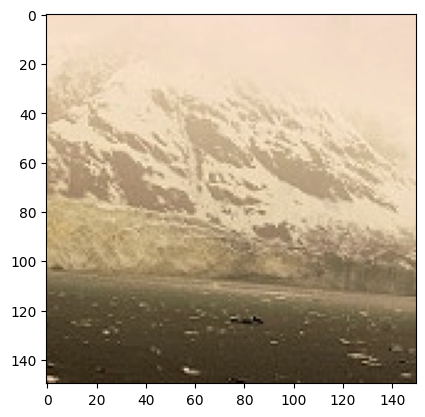

In [197]:
train_dataset, test_dataset = preproc_data()

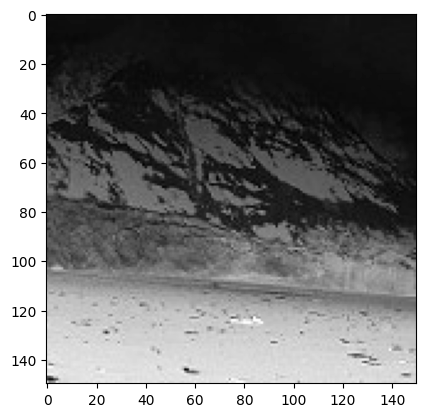

In [97]:
plt.imshow(train_dataset[0][0].numpy(), cmap="Greys")

[[[229 108 154]
  [229 108 154]
  [229 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [226 108 154]]

 [[227 108 154]
  [228 108 154]
  [228 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [227 108 154]]

 [[228 108 154]
  [228 108 154]
  [228 108 154]
  ...
  [227 108 154]
  [227 108 154]
  [227 108 154]]

 ...

 [[178 105 155]
  [175 105 155]
  [144 107 154]
  ...
  [ 98 103 151]
  [ 67 103 149]
  [ 65 103 149]]

 [[199 106 157]
  [227 107 157]
  [227 108 156]
  ...
  [ 56 103 148]
  [ 60 102 148]
  [ 65 102 149]]

 [[ 63 107 153]
  [137 107 158]
  [124 110 156]
  ...
  [ 49 103 148]
  [ 49 102 147]
  [ 65 102 149]]]
[[[246 222 201]
  [246 222 201]
  [246 222 201]
  ...
  [244 219 199]
  [244 219 199]
  [243 218 198]]

 [[244 219 199]
  [245 221 200]
  [245 221 200]
  ...
  [244 219 199]
  [244 219 199]
  [244 219 199]]

 [[245 221 200]
  [245 221 200]
  [245 221 200]
  ...
  [244 219 199]
  [244 219 199]
  [244 219 199]]

 ...

 [[185 168 145]
  [182 165 142]
  [153 132 111]
  ..

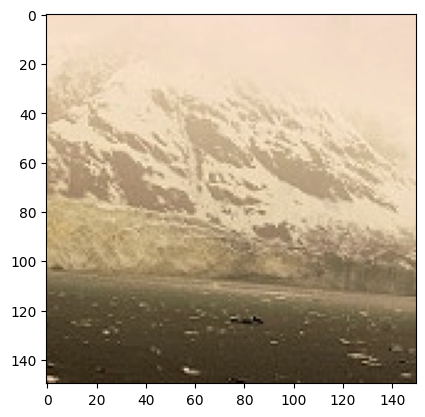

In [198]:
rs = np.uint8(torch.cat((train_dataset[0][0].view(150, 150, 1), train_dataset[0][1]), dim=2))
print(rs)
rs = cv2.cvtColor(rs, cv2.COLOR_LUV2RGB)
print(rs)
plt.imshow(rs)